In [1]:
trainDir = "training"
testDir = "validation"

In [25]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, MultiHeadAttention, LayerNormalization, Reshape, Add, Input, Lambda
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.utils import class_weight 

In [3]:
def transformer_block(units, num_heads, dropout_rate=0.1):
    # Define inputs for the transformer block
    inputs = Input(shape=(None, units))  # None allows dynamic sequence length

    # Multi-head attention layer
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=units)(inputs, inputs)
    attn_output = Dropout(dropout_rate)(attn_output)
    attn_output = Add()([inputs, attn_output])  # Residual connection
    attn_output = LayerNormalization(epsilon=1e-6)(attn_output)  # Normalize

    # Feed-forward network
    ff_output = Dense(units, activation='relu')(attn_output)
    ff_output = Dropout(dropout_rate)(ff_output)
    ff_output = Add()([attn_output, ff_output])  # Another residual connection
    outputs = LayerNormalization(epsilon=1e-6)(ff_output)  # Normalize

    # Return the transformer block as a model
    return Model(inputs=inputs, outputs=outputs)

In [ ]:
# Step 1: Data Preprocessing
splits = [0.2]  # Example: 8:2 
results = []

for i, split in enumerate(splits, start=1):
    data_gen = ImageDataGenerator(rescale=1.0/255.0, validation_split=split)
    
    train_data = data_gen.flow_from_directory(
        trainDir,
        target_size=(128, 128),
        batch_size=32,
        class_mode='binary',
        subset='training'
    )
    val_data = data_gen.flow_from_directory(
        trainDir,
        target_size=(128, 128),
        batch_size=32,
        class_mode='binary',
        subset='validation'
    )

transformer = transformer_block(units=128, num_heads=4)

# Step 2: Building the CNN Model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'), 
    Reshape((1, 128)),                #Reshape to (sequence length, units) for transformer

    #  # Add transformer block
    # transformer,

    Flatten(),  # Flatten back for fully connected layers
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

labels = train_data.classes  # Array of 0s and 1s for binary classes
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights_dict = dict(enumerate(class_weights))

# Step 3: Training the Model
history = model.fit(
    train_data,
    epochs=15,
    validation_data=val_data,
    # class_weight=class_weights_dict,
)
val_loss, val_accuracy = model.evaluate(train_data)





Found 5722 images belonging to 2 classes.
Found 1430 images belonging to 2 classes.
Epoch 1/15


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/179 ━━━━━━━━━━━━━━━━━━━━ 17s 217ms/step - accuracy: 0.7165 - loss: 0.6057

In [39]:
import pandas as pd
results.append({
        "No": i,
        "Training Images": train_data.samples,
        "Testing Images": val_data.samples,
        "Splitting Ratio": f"{int((1 - split) * 10)}:{int(split * 10)}",
        "Accuracy (%)": round(val_accuracy * 100, 2)
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)
print(results_df)

   No  Training Images  Testing Images Splitting Ratio  Accuracy (%)
0   1             5007            2145             7:3         100.0


In [40]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
import numpy as np

# Step 1: Get Predictions
val_predictions = model.predict(val_data)
val_predictions = (val_predictions > 0.5).astype(int)  # Convert probabilities to binary predictions (0 or 1)

# Step 2: Get True Labels
val_labels = val_data.classes  # Ground truth labels

# Step 3: Calculate Precision, Recall, and F1-Score
precision = precision_score(val_labels, val_predictions)
recall = recall_score(val_labels, val_predictions)
f1 = f1_score(val_labels, val_predictions)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

# Detailed Classification Report
print("\nClassification Report:")
print(classification_report(val_labels, val_predictions))


 3/68 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step
Precision: 0.68
Recall: 0.74
F1-Score: 0.71

Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.24      0.26       676
           1       0.68      0.74      0.71      1469

    accuracy                           0.58      2145
   macro avg       0.48      0.49      0.48      2145
weighted avg       0.56      0.58      0.57      2145



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


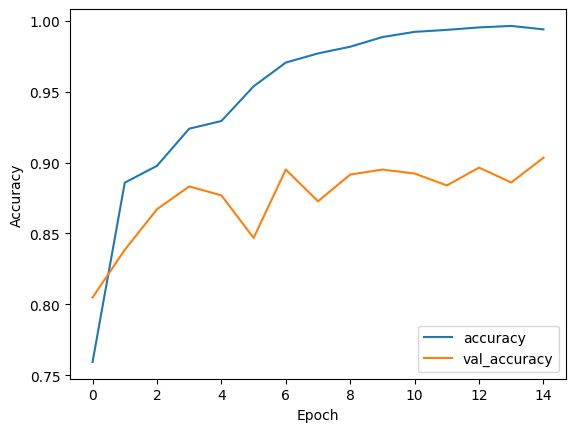

In [18]:
# Step 4: Evaluate the Model
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [12]:
def predict_tumor(image_path, threshold=0.5):
    # Load and preprocess the image
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(128, 128))
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    # Make prediction
    prediction = model.predict(img_array)
    confidence = prediction[0][0] * 100  # Convert to percentage
    
    # Determine the result
    if prediction[0] > threshold:
        result = "Tumor Detected"
        confidence_level = confidence  # Confidence for "Tumor Detected"
    else:
        result = "No Tumor Detected"
        confidence_level = 100 - confidence  # Confidence for "No Tumor Detected"
    
    return result, confidence_level


In [ ]:
from pathlib import Path
from PIL import UnidentifiedImageError  # Import this to handle specific image errors

folder_path = Path('validation/notumor')

for file_path in folder_path.iterdir():
    if file_path.is_file() and file_path.suffix in ['.jpg', '.jpeg', '.png']:  # Filter only image files
        try:
            print(predict_tumor(file_path))
        except UnidentifiedImageError:
            print(f"Skipping file {file_path} as it is not a valid image.")


In [14]:
result, confidence = predict_tumor("/Users/dpak/Desktop/brain/No19.jpg")
print(f"Prediction: {result}, Confidence Level: {confidence:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Prediction: No Tumor Detected, Confidence Level: 99.98%


In [20]:
import collections
print(collections.Counter(val_labels))


Counter({np.int32(1): 979, np.int32(0): 451})
